The **Traveling Salesperson Problem (TSP)** is a well-known combinatorial optimization problem that seeks to determine a least cost route for a salesperson to visit a given set of cities exactly once and return to the starting point. Formally, it is defined on a weighted graph where nodes represent cities, edges represent connections between cities, and edge weights denote travel costs (such as distance or time). The objective is to minimize the total travel cost while ensuring that each city is visited once.

## Import Packages and Read Data

In [41]:
import gurobipy as gp
from gurobipy import quicksum as qsum 
from gurobipy import GRB
import pandas as pd
import util
import networkx as nx
import matplotlib.pyplot as plt
import time
# import tsp_map
import itertools
import numpy as np
import heapq
from typing import List, Callable, Any, Optional

In [42]:
np.random.seed(1)

## Cities

In [43]:
df_cities = pd.read_csv('cities.csv')
print(df_cities.head(10))

         City Airport Code  Latitude  Longitude  X Coordinate  Y Coordinate
0      Dallas          ADS  32.96856  -96.83644  3.131644e+06  1.136450e+06
1  Washington          WSG  40.13647  -80.29019  4.971502e+06  2.129998e+06
2      Denver          APA  39.57012 -104.84929  2.240656e+06  2.047965e+06
3      Austin          AUM  43.66264  -92.93292  3.565695e+06  2.656997e+06
4   Nashville          BNA  36.12447  -86.67818  4.261190e+06  1.562602e+06
5      Boston          BOS  42.36294  -71.00639  6.003813e+06  2.459338e+06
6   Charlotte          CLT  35.21375  -80.94906  4.898239e+06  1.437947e+06
7     Houston          CXO  30.35340  -95.41508  3.289691e+06  7.947587e+05
8     Detroit          DET  42.40933  -83.01017  4.669054e+06  2.466322e+06
9     Phoenix          DVT  33.68831 -112.08256  1.436353e+06  1.232237e+06


## Visualization

First, create the graph

In [44]:
dist_min = 0
dist_max = 5000
G = util.get_cities_graph(df_cities, dist_min, dist_max)

Next, draw the graph.

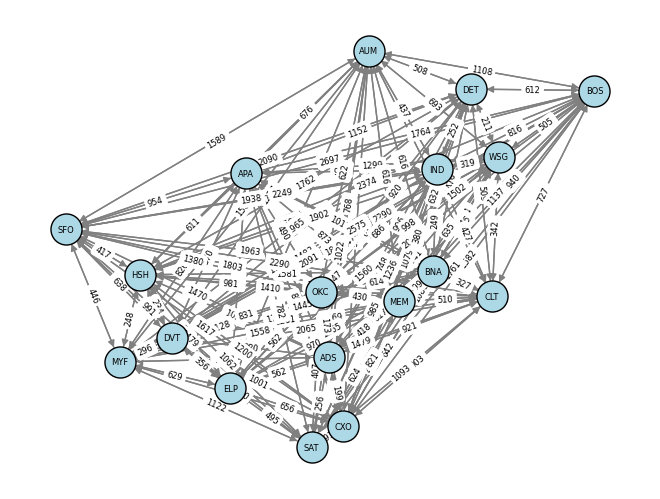

In [45]:
pos = nx.get_node_attributes(G, 'pos')
labels = nx.get_edge_attributes(G, 'weight')
formatted_labels = {k: f"{int(v)}" for k, v in labels.items()}
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', 
        edge_color='gray', font_size=6, edgecolors='black')

nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_labels, 
                             font_size=6);

## Nearest Neighbor Heuristic

Implement a version of the nearest neighobr heuristic that allows the user to change the starting node.

In [46]:
def nearest_neighbor_heuristic(G : nx.DiGraph):
    visited = []
    current_node = list(G.nodes())[0]
    visited.append(current_node)
    while len(visited) < len(G.nodes()):
        neighbors = [j for j in G.neighbors(current_node) 
                     if j not in visited]
        nearest_neighbor = min(neighbors, 
            key=lambda node: G[current_node][node]['weight'])
        current_node = nearest_neighbor
        visited.append(current_node)
    visited.append(visited[0])
    return visited

## Get Solution When Starting at First Node

In [47]:
def get_cost(edges_used):
    return sum(G[u][v]['weight'] for u, v in edges_used)

In [48]:
start_time = time.time()
nn_tour = nearest_neighbor_heuristic(G)
end_time = time.time()
execution_time = round(end_time - start_time, 4)
print("Tour:", nn_tour)
edges_used_nn = list(zip(nn_tour, nn_tour[1:]))
cost = get_cost(edges_used_nn)
formatted_cost = round(cost)
print("Cost of tour:", formatted_cost)
print("Optimization time:", execution_time, "seconds")

Tour: ['ADS', 'OKC', 'CXO', 'SAT', 'ELP', 'DVT', 'HSH', 'MYF', 'SFO', 'APA', 'AUM', 'IND', 'BNA', 'MEM', 'CLT', 'WSG', 'DET', 'BOS', 'ADS']
Cost of tour: 8255
Optimization time: 0.0002 seconds


## Visualize Solution

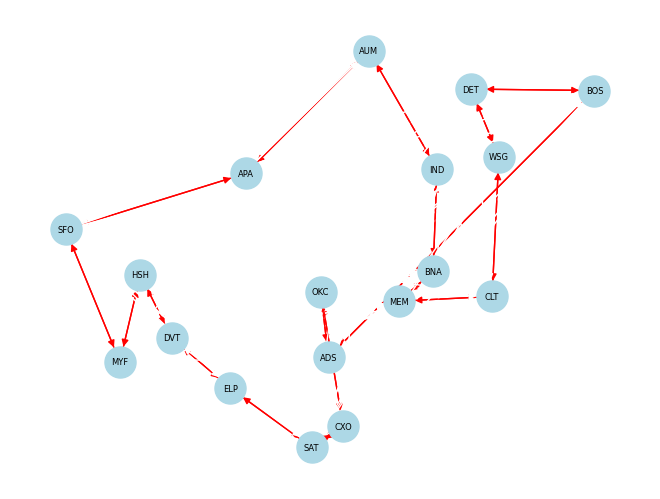

In [49]:
edge_colors = ['red' if (u, v) in edges_used_nn or (v,u) in edges_used_nn else 'white' 
               for u, v in G.edges()]
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', 
        edge_color=edge_colors, font_size=6)

## Local Search

In [50]:
def swap_nodes(tour, i, j):
    new_tour = tour[:]
    new_tour[i], new_tour[j] = tour[j], tour[i]
    return new_tour

def get_city_swaps_neighborhood(tour):
    ''' Returns a generator of all possible solutions in the neighborhood of the current solution '''
    temp_tour = tour[:-1] # remove the last node (same as the first)
    for i,j in itertools.combinations(range(len(temp_tour)), 2):
        new_tour = swap_nodes(temp_tour, i, j)
        new_tour = new_tour + [new_tour[0]] # add the first node to the end
        yield new_tour

def choose_first_improving_solution_from_neighborhood(cost_of_tour, neighborhood):
    ''' Returns the first solution in the neighborhood that has a lower cost than the current solution '''
    for neighbor in neighborhood:
        edges_used = list(zip(neighbor, neighbor[1:]))
        cost = get_cost(edges_used)
        if cost < cost_of_tour:
            return neighbor
    return None

In [51]:
def local_search_heuristic(G, current_tour,
                        neighborhood_generator = get_city_swaps_neighborhood, 
                        choose_fn = choose_first_improving_solution_from_neighborhood):
    edges_used = list(zip(current_tour, current_tour[1:]))
    best_cost = get_cost(edges_used)
    tour = current_tour[:]
    while True:
        next_solution = choose_fn(best_cost, neighborhood_generator(tour))
        if next_solution is not None:
            print("Improving solution: ", next_solution)
            tour = next_solution
            best_cost = sum(G[u][v]['weight'] 
                            for u, v in zip(next_solution, next_solution[1:]))
        else:
            print("No improving solution found")
            break
    return tour

In [52]:
print("Initial tour:", nn_tour)
edges_used = list(zip(nn_tour, nn_tour[1:]))
cost = round(get_cost(edges_used))
print("Initial cost:", cost)
print("Running city swap heuristic...")
start_time = time.time()
new_tour = local_search_heuristic(G, nn_tour)
end_time = time.time()
execution_time = round(end_time - start_time, 4)
print("New tour:", new_tour)
edges_used = list(zip(new_tour, new_tour[1:]))
cost = round(get_cost(edges_used))
print("Cost of new tour:", cost)

Initial tour: ['ADS', 'OKC', 'CXO', 'SAT', 'ELP', 'DVT', 'HSH', 'MYF', 'SFO', 'APA', 'AUM', 'IND', 'BNA', 'MEM', 'CLT', 'WSG', 'DET', 'BOS', 'ADS']
Initial cost: 8255
Running city swap heuristic...
Improving solution:  ['OKC', 'ADS', 'CXO', 'SAT', 'ELP', 'DVT', 'HSH', 'MYF', 'SFO', 'APA', 'AUM', 'IND', 'BNA', 'MEM', 'CLT', 'WSG', 'DET', 'BOS', 'OKC']
Improving solution:  ['OKC', 'ADS', 'CXO', 'SAT', 'ELP', 'DVT', 'HSH', 'MYF', 'SFO', 'APA', 'AUM', 'IND', 'MEM', 'BNA', 'CLT', 'WSG', 'DET', 'BOS', 'OKC']
Improving solution:  ['OKC', 'ADS', 'CXO', 'SAT', 'ELP', 'DVT', 'HSH', 'MYF', 'SFO', 'APA', 'AUM', 'IND', 'MEM', 'BNA', 'CLT', 'BOS', 'DET', 'WSG', 'OKC']
Improving solution:  ['OKC', 'ADS', 'CXO', 'SAT', 'ELP', 'DVT', 'HSH', 'MYF', 'SFO', 'APA', 'AUM', 'IND', 'MEM', 'BNA', 'CLT', 'BOS', 'WSG', 'DET', 'OKC']
No improving solution found
New tour: ['OKC', 'ADS', 'CXO', 'SAT', 'ELP', 'DVT', 'HSH', 'MYF', 'SFO', 'APA', 'AUM', 'IND', 'MEM', 'BNA', 'CLT', 'BOS', 'WSG', 'DET', 'OKC']
Cost of ne

In [53]:
def choose_most_improving_solution_from_neighborhood(cost_of_tour, neighborhood):
    ''' Returns the solution in the neighborhood that has a lowest cost'''
    best_neighbor = None
    best_cost = cost_of_tour
    i = 0
    for neighbor in neighborhood:
        edges_used = list(zip(neighbor, neighbor[1:]))
        cost = get_cost(edges_used)
        if cost < best_cost:
            best_cost = cost
            best_neighbor = neighbor
        i += 1
    return best_neighbor

In [54]:
print("Running city swap heuristic...")
start_time = time.time()
new_tour = local_search_heuristic(G, nn_tour, 
        choose_fn = choose_most_improving_solution_from_neighborhood)
end_time = time.time()
execution_time = round(end_time - start_time, 4)
print("New tour:", new_tour)
edges_used = list(zip(new_tour, new_tour[1:]))
cost = round(get_cost(edges_used))
print("Cost of new tour:", cost)

Running city swap heuristic...
Improving solution:  ['ADS', 'OKC', 'CXO', 'SAT', 'ELP', 'DVT', 'HSH', 'MYF', 'SFO', 'APA', 'AUM', 'IND', 'BNA', 'MEM', 'CLT', 'WSG', 'BOS', 'DET', 'ADS']
Improving solution:  ['OKC', 'ADS', 'CXO', 'SAT', 'ELP', 'DVT', 'HSH', 'MYF', 'SFO', 'APA', 'AUM', 'IND', 'BNA', 'MEM', 'CLT', 'WSG', 'BOS', 'DET', 'OKC']
Improving solution:  ['OKC', 'ADS', 'CXO', 'SAT', 'ELP', 'DVT', 'HSH', 'MYF', 'SFO', 'APA', 'AUM', 'IND', 'MEM', 'BNA', 'CLT', 'WSG', 'BOS', 'DET', 'OKC']
Improving solution:  ['OKC', 'ADS', 'CXO', 'SAT', 'ELP', 'DVT', 'HSH', 'MYF', 'SFO', 'APA', 'AUM', 'IND', 'MEM', 'BNA', 'CLT', 'BOS', 'WSG', 'DET', 'OKC']
No improving solution found
New tour: ['OKC', 'ADS', 'CXO', 'SAT', 'ELP', 'DVT', 'HSH', 'MYF', 'SFO', 'APA', 'AUM', 'IND', 'MEM', 'BNA', 'CLT', 'BOS', 'WSG', 'DET', 'OKC']
Cost of new tour: 7686


## Simulated Annealing

In [55]:
def multiplicative_cool(temperature : float, 
                        alpha : float = 0.9):
    return alpha*temperature

def get_random_swap_neighbor(tour : list):
    temp_tour = tour[:-1]
    pair = np.random.choice(list(range(len(temp_tour))), 2, replace = False)
    new_tour = swap_nodes(temp_tour, pair[0], pair[1])
    return  new_tour + [new_tour[0]]

def get_cost_of_solution(tour : list):
    edges_used = list(zip(tour, tour[1:]))
    return round(get_cost(edges_used))

def get_boltzmann_prob(current_obj : float, new_obj : float,
                       temperature : float):
    return np.exp(-(new_obj - current_obj)/temperature) # assumes minimization

In [56]:
def run_simulated_annealing(init_soln : list, 
                            init_temp : float,
                            cool_fn : multiplicative_cool,
                            get_rand_neighbor : get_random_swap_neighbor,
                            get_accept_prob : get_boltzmann_prob,
                            max_iter : int,
                            log = False):
    solution = [city for city in init_soln]
    best_solution = solution
    T = init_temp
    for t in range(max_iter):
        candidate_soln = get_rand_neighbor(solution)
        current_cost = get_cost_of_solution(solution)
        new_cost = get_cost_of_solution(candidate_soln)
        if log:
            print("Iteration", t, ":", current_cost, new_cost, round(T,1))
            print("Candidate solution:", candidate_soln)
        if new_cost <= current_cost:
            solution = candidate_soln
            if log:
                print("Accepting better or same solution")
        elif np.random.rand() <= get_accept_prob(current_cost, new_cost, T):
            solution = candidate_soln
            if log:
                print("Accepting worse solution", get_accept_prob(current_cost, new_cost, T))
        T = cool_fn(T)
    return best_solution

In [57]:
print("init tour:", nn_tour)
print("cost of tour:", get_cost_of_solution(nn_tour))
tour = run_simulated_annealing(init_soln=nn_tour, 
                        init_temp=100,
                        cool_fn = multiplicative_cool,
                        get_rand_neighbor = get_random_swap_neighbor,
                        get_accept_prob = get_boltzmann_prob,
                        max_iter=100,
                        log=True)
print("tour:", tour)
print("cost of tour:", get_cost_of_solution(tour))

init tour: ['ADS', 'OKC', 'CXO', 'SAT', 'ELP', 'DVT', 'HSH', 'MYF', 'SFO', 'APA', 'AUM', 'IND', 'BNA', 'MEM', 'CLT', 'WSG', 'DET', 'BOS', 'ADS']
cost of tour: 8255
Iteration 0 : 8255 10837 100
Candidate solution: ['ADS', 'OKC', 'CXO', 'HSH', 'ELP', 'DVT', 'SAT', 'MYF', 'SFO', 'APA', 'AUM', 'IND', 'BNA', 'MEM', 'CLT', 'WSG', 'DET', 'BOS', 'ADS']
Iteration 1 : 8255 13265 90.0
Candidate solution: ['ADS', 'OKC', 'CXO', 'SAT', 'ELP', 'CLT', 'HSH', 'MYF', 'SFO', 'APA', 'AUM', 'IND', 'BNA', 'MEM', 'DVT', 'WSG', 'DET', 'BOS', 'ADS']
Iteration 2 : 8255 9093 81.0
Candidate solution: ['ADS', 'OKC', 'ELP', 'SAT', 'CXO', 'DVT', 'HSH', 'MYF', 'SFO', 'APA', 'AUM', 'IND', 'BNA', 'MEM', 'CLT', 'WSG', 'DET', 'BOS', 'ADS']
Iteration 3 : 8255 9368 72.9
Candidate solution: ['ADS', 'OKC', 'CXO', 'SAT', 'ELP', 'DVT', 'HSH', 'MYF', 'SFO', 'APA', 'CLT', 'IND', 'BNA', 'MEM', 'AUM', 'WSG', 'DET', 'BOS', 'ADS']
Iteration 4 : 8255 8616 65.6
Candidate solution: ['ADS', 'OKC', 'CXO', 'SAT', 'ELP', 'DVT', 'HSH', 'MYF

# Genetic Algorithm

First, let's talk about a strange/wild/weird feature of Python ... wrappers.

In [112]:
def normalize_list(lst: List[float]) -> List[float]:
    total = sum(lst)
    return [x/total for x in lst]

def generate_fitness_function(transform_fn):
    def decorator(func):
        def wrapper(chromosome : list):
            return func(transform_fn(chromosome))
        return wrapper
    return decorator

def squares_fn(lst : list):
    return sum([x**2 for x in lst])

sum_squares_normalized = generate_fitness_function(normalize_list)(squares_fn)

my_list = list(range(3))
               
print("sum of squares of normalized list", sum_squares_normalized(my_list))

sum of squares of normalized list 0.5555555555555556


In [113]:
normalized = normalize_list(my_list)
print("sum of squares of normalized list", sum(x**2 for x in normalized))

sum of squares of normalized list 0.5555555555555556


In [97]:
def ordinal_transformation(chromosome : list):
    # fill this in
    pass
    #return

def reverse_ordinal_transformation(chromosome : list):
    # fill this in
    pass
    #return

In [ ]:
def get_cost_of_tour(tour : list):
    edges_used = list(zip(tour, tour[1:]))
    return round(get_cost(edges_used))

In [ ]:
# fit_fn = generate_fitness_function(reverse_ordinal_transformation)(get_cost_of_tour)

In [ ]:
def roulette_wheel_select(population : List[list], fitness_fn):
    # fill this in
    pass
    #return parent1, parent2 (uncomment this line)

In [58]:
def two_pt_crossover(parent1 : list, parent2 : list):
    # fill this in
    pass
    #return

In [ ]:
def rand_swap_mutate(chromosome : list): 
    # fill this in
    pass
    #return

In [ ]:
def get_top_k_items(lst: List[Any], k: int, key: Callable[[Any], Any]) -> List[Any]:
    return heapq.nlargest(k, lst, key=key)

In [77]:
def run_genetic_algorithm(init_pop : List[list], 
                            crossover_rate : float,
                            mutation_rate : float,
                            fitness_fn,
                            selection_fn,
                            crossover_fn,
                            mutation_fn,
                            transform_fn,
                            reverse_transform_fn,
                            max_iter : int,
                            log = False):
    num_crossovers = int(crossover_rate*len(init_pop))
    num_mutations = int(mutation_rate*len(init_pop))
    population = [transform_fn(soln) for soln in init_pop]
    fit_fn = generate_fitness_function(transform_fn)(fitness_fn)
    for t in range(max_iter):
        avg_fitness = np.mean([fit_fn(soln) for soln in population])
        parents = [(selection_fn(population), selection_fn(population)) for i in range(num_crossovers)]
        offspring = [crossover_fn(parent1, parent2) for parent1, parent2 in parents]
        mutations = [mutation_fn(selection_fn(population)) for i in range(num_mutations)]
        population = get_top_k_items(population + offspring + mutations, len(population), fit_fn)
        avg_fitness = np.mean([fit_fn(soln) for soln in population])
        if log:
            print("Iteration", t, ":", avg_fitness)
    best_chromosome = max(population, key = lambda x: fit_fn(x))
    return reverse_transform_fn(best_chromosome)

In [60]:
random_tours = [np.random.permutation(list(G.nodes())) for i in range(10)]
ga_tour = run_genetic_algorithm(init_pop = random_tours,
                                crossover_rate=0.3,
                                mutation_rate=0.1,
                                fitness_fn=get_cost_of_tour, # inputs solutions in the same format as init_pop
                                selection_fn=roulette_wheel_select,
                                crossover_fn=two_pt_crossover,
                                mutation_fn=rand_swap_mutate,
                                transform_fn = ordinal_transformation,
                                reverse_transform_fn = reverse_ordinal_transformation,
                                max_iter=100,
                                log=True)

print("tour:", ga_tour)
print("cost of tour:", get_cost_of_solution(ga_tour))

TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'